In [10]:
import torch
from torch.nn import functional as F 
import matplotlib.pyplot as plt
import random

In [11]:
# Fetch all names from the file
names = []
with open('names.txt') as file:
    for name in file.read().splitlines():
        names.append(name)
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [12]:
# Build vocab
chars = sorted(set(".".join(names)))

stoi = {ch: i for i,ch in enumerate(chars)}
itos = {i:ch for ch, i in stoi.items()}
vocab = len(itos)

print(f"Size of {vocab = }") 

Size of vocab = 27


In [13]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):
  X, Y = [], []
  for w in names:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_train, y_train = build_dataset(names[:n1])
X_dev, y_dev = build_dataset(names[n1:n2])
X_test, y_test = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [62]:
# init params
n_dims = 10 # no of dimens of Embedding Vector
n_hidden = 200 # no of nuerons in the hidden layer
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab, n_dims, generator=g)
W1 = torch.randn(n_dims * block_size, n_hidden, generator=g) * (5/3)/((n_dims * block_size) ** 0.5)  # HE initialization
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn(n_hidden, vocab, generator=g) * 0.01
b2 = torch.randn(vocab, generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

In [63]:
no_params = sum(p.nelement() for p in parameters)

no_params

12097

In [64]:
for p in parameters:
    p.requires_grad = True

In [65]:
# How to pick a better learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [66]:
losses = []
max_steps = 200000
for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (100,))
    # input layer
    embedding = C[X_train[ix]].view(X_train[ix].shape[0], -1)
    # Linear layer
    preact = embedding @ W1 #+b1
    # Batch Norm
    bn_mean = preact.mean(0, keepdim=True)
    bn_std = preact.std(0, keepdim=True)
    preact = bngain * (preact - bn_mean) / bn_std + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bn_mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bn_std
    # Activation
    h = torch.tanh(preact)
    # Output layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    #backward prop
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update params
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
print(f"{losses[-1]}")

      0/ 200000: 3.2853
  10000/ 200000: 2.1819
  20000/ 200000: 2.1869
  30000/ 200000: 2.0904
  40000/ 200000: 2.0733
  50000/ 200000: 2.0338
  60000/ 200000: 2.0713
  70000/ 200000: 2.0947
  80000/ 200000: 2.4409
  90000/ 200000: 2.1532
 100000/ 200000: 2.1783
 110000/ 200000: 2.1042
 120000/ 200000: 1.9672
 130000/ 200000: 2.2217
 140000/ 200000: 2.1010
 150000/ 200000: 2.1367
 160000/ 200000: 2.0504
 170000/ 200000: 1.9877
 180000/ 200000: 1.9026
 190000/ 200000: 1.8821
0.2962450087070465


In [67]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  X,y = {
    'train': (X_train, y_train),
    'val': (X_dev, y_dev),
    'test': (X_test, y_test),
  }[split]
  emb = C[X] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.035623788833618
val 2.0951263904571533


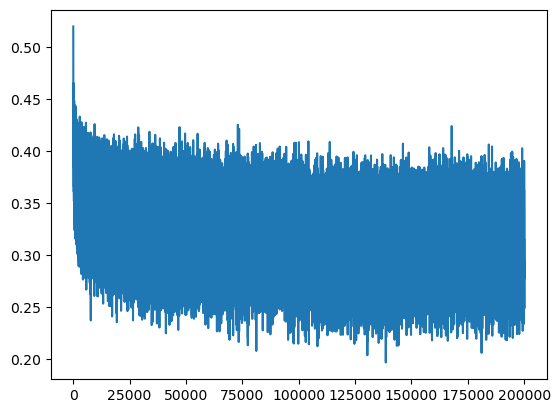

In [55]:
plt.plot(losses)

In [56]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

chrpahzldi.
llvith.
mlix.
thty.
sklasskynl.
bubbddhetric.
vregi.
shannithchrishby.
legz.
shbhrtdin.
quqjuss.
linghbvaniquwlutrygdifryxi.
frydini.
sabbbdde.
siq.
gtlechylan.
varqembysj.
ksymberqany.
zelph.
jkmislak.


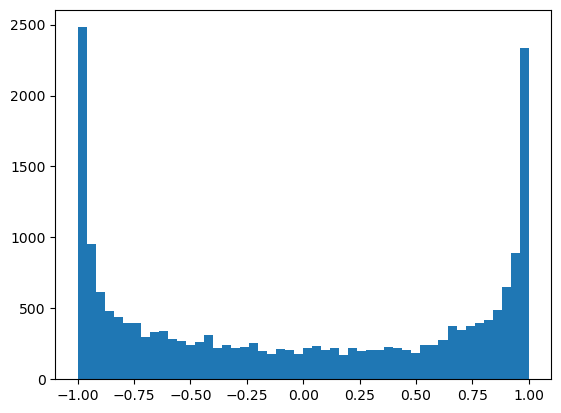

In [68]:
plt.hist(h.view(-1).tolist(), 50);

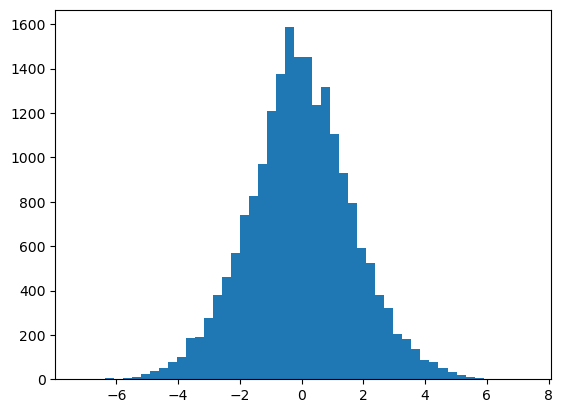

In [69]:
plt.hist(preact.view(-1).tolist(), 50);

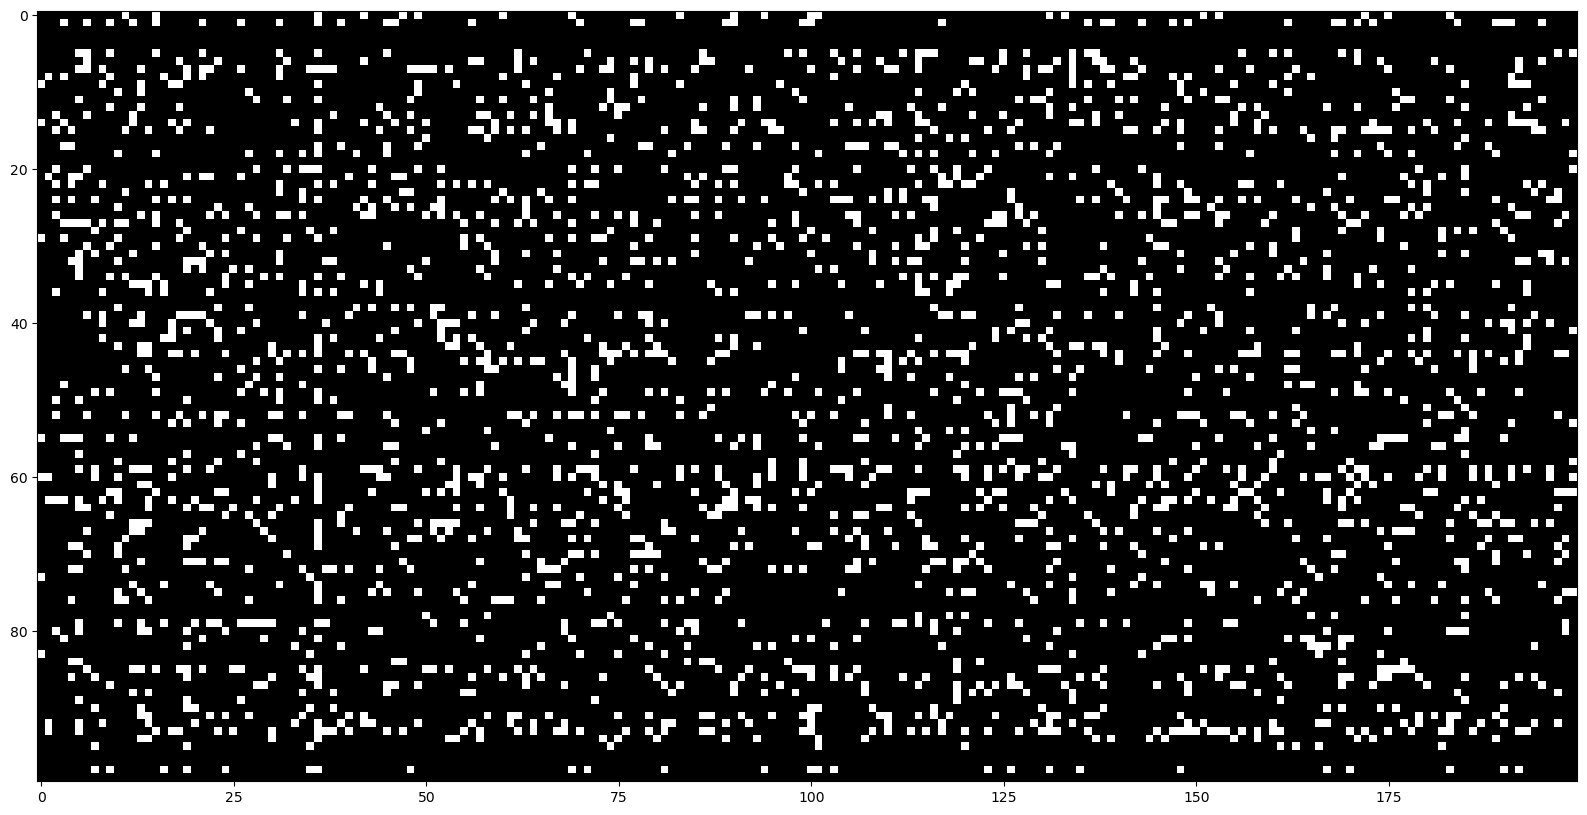

In [70]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

## Torchify the code

In [ ]:
class Linear:

    def __init__(self, fan_in, fan_out, bais=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, X):
        self.out = X @ self.weight
        if self.bais:
            self.out += self.bais
        return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
